<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/Scratch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scratch CNN**
---
Classification model for discriminating between 2 classes: **masses and calcification**. *Ad-hoc CNN architecture*.

**Students:**   *A. Schiavo - M. Gómez - M. Daole*



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import os 

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project/numpy data"
train_img_path = os.path.join(base_path, 'train_tensor.npy')
train_label_path = os.path.join(base_path, 'train_labels.npy')
test_img_path = os.path.join(base_path, 'public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'public_test_labels.npy')

2.4.0


In [ ]:
# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)


Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


## Data preprocessing

Currently, our data sits on a drive as numpy files (**.npy**), so the steps for getting it into our network are roughly:



In [ ]:
# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

In [ ]:
#print(train_labels[2000])
#print(labels[:10])
print(train_images.shape)

# verify values range: getting max value 
print(max([np.max(image) for image in train_images])) # max is 65'535 


(2676, 150, 150)
65535


In [ ]:
train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
print(train_images.shape)
print(test_images.shape)

(2676, 150, 150, 1)
(336, 150, 150, 1)


In [ ]:
# split dataset into training and validation set 70-30
train_images_split = train_images[:int(0.7*len(train_images))]
valid_images_split = train_images[int(0.7*len(train_images)):]
train_labels_split = labels[:int(0.7*len(labels))]
valid_labels_split = labels[int(0.7*len(labels)):]

print(train_images_split.shape)
print(valid_images_split.shape)                                       

(1873, 150, 150, 1)
(803, 150, 150, 1)


In [ ]:
BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./65535
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

for batch, labels_batch in train_datagen.flow(train_images, labels, batch_size=BATCH_SIZE):
  print(batch.shape)
  print(labels_batch.shape)
  break



(20, 150, 150, 1)
(20,)


## Defining CNN 


In [ ]:
from keras import layers
from keras import optimizers 
from keras import models
from keras import regularizers

def build_model(loss_function, eval_metric):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  #model.add(layers.Dense(512, activation='relu'))
  #model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-4), # lr = 0.0001
              metrics=["acc"]) 
  
  return model 

## CNN Compilation:



In [ ]:
from keras import optimizers 

model = build_model("binary_crossentropy", "acc")

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 15, 15, 128)     

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)


Epoch 1/100
93/93 [==============================] - 3s 23ms/step - loss: 1.4376 - acc: 0.5409 - val_loss: 1.0533 - val_acc: 0.5300
Epoch 2/100
93/93 [==============================] - 2s 21ms/step - loss: 0.9753 - acc: 0.5859 - val_loss: 0.7825 - val_acc: 0.7362
Epoch 3/100
93/93 [==============================] - 2s 20ms/step - loss: 0.7565 - acc: 0.6739 - val_loss: 0.7703 - val_acc: 0.5537
Epoch 4/100
93/93 [==============================] - 2s 21ms/step - loss: 0.6583 - acc: 0.7288 - val_loss: 0.6054 - val_acc: 0.7312
Epoch 5/100
93/93 [==============================] - 2s 21ms/step - loss: 0.6084 - acc: 0.7647 - val_loss: 0.5904 - val_acc: 0.7337
Epoch 6/100
93/93 [==============================] - 2s 21ms/step - loss: 0.5806 - acc: 0.7804 - val_loss: 0.5964 - val_acc: 0.7150
Epoch 7/100
93/93 [==============================] - 2s 21ms/step - loss: 0.5829 - acc: 0.7713 - val_loss: 0.7992 - val_acc: 0.6112
Epoch 8/100
93/93 [==============================] - 2s 21ms/step - loss: 0.

KeyboardInterrupt: ignored

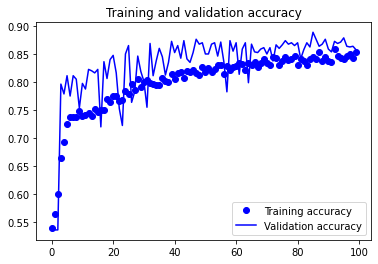

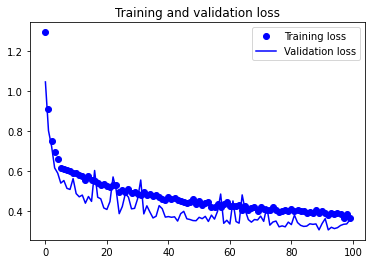

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 0.3748 - acc: 0.8438
0.84375


These plots are characteristic of **overfitting**. Training accuracy keeps increasing linearly while validation accuracy stalls around **82%**.

##Fighting overfitting: 1. Data Augmentation:


In [ ]:
from tensorflow.keras.preprocessing import image

# train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

"""
x = train_images[0].reshape((1,) + train_images[0].shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break

plt.show()
"""

'\nx = train_images[0].reshape((1,) + train_images[0].shape)\n\ni = 0\nfor batch in train_datagen.flow(x, batch_size=1):\n  plt.figure(i)\n  imgplot = plt.imshow(image.array_to_img(batch[0]))\n  i += 1\n  if i % 4 == 0:\n    break\n\nplt.show()\n'

In [ ]:
model = build_model("binary_crossentropy", "acc")

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 15, 15, 128)     

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
93/93 [==============================] - 5s 47ms/step - loss: 0.6919 - acc: 0.5495 - val_loss: 0.6902 - val_acc: 0.5362
Epoch 2/100
93/93 [==============================] - 4s 44ms/step - loss: 0.6885 - acc: 0.5487 - val_loss: 0.6680 - val_acc: 0.5362
Epoch 3/100
93/93 [==============================] - 4s 43ms/step - loss: 0.6726 - acc: 0.5703 - val_loss: 0.6351 - val_acc: 0.6925
Epoch 4/100
93/93 [==============================] - 4s 44ms/step - loss: 0.6428 - acc: 0.6235 - val_loss: 0.5710 - val_acc: 0.7800
Epoch 5/100
93/93 [==============================] - 4s 44ms/step - loss: 0.6074 - acc: 0.6837 - val_loss: 0.5163 - val_acc: 0.8175
Epoch 6/100
93/93 [==============================] - 4s 44ms/step - loss: 0.5903 - acc: 0.7037 - val_loss: 0.5499 - val_acc: 0.6825
Epoch 7/100
93/93 [==============================] - 4s 44ms/step - loss: 0.5758 - acc: 0.7104 - val_loss: 0.4816 - val_acc: 0.8075
Epoch 8/100
93/93 [==============================] - 4s 45ms/step - loss: 0.

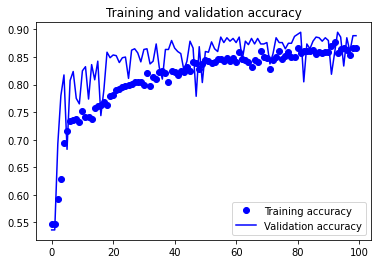

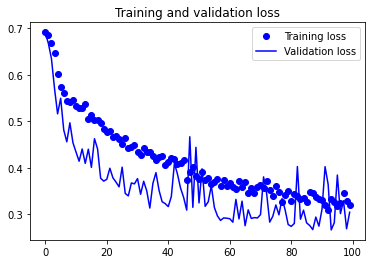

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 0.3545 - acc: 0.8500
0.8500000238418579


##K-fold cross validation.


In [ ]:
print(train_images.shape)

# train data augmentation for k-fold-cross-validation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)

(2676, 150, 150, 1)


In [ ]:
def cross_validate(k, batch_size, num_epochs, dataset, targets, verbosity):
  #10-Fold-Cross-Validation
  num_val_samples = len(dataset) // k 
  validation_accuracies = []
  validation_losses = []

  for i in range(k):
    # rigen augmented data 
    
    print("processing fold #", i)
    validation_data = dataset[i * num_val_samples : (i + 1) * num_val_samples]
    validation_labels = targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [dataset[:i * num_val_samples],
        dataset[(i + 1) * num_val_samples:]], 
        axis=0)

    partial_train_targets = np.concatenate(
        [targets[:i * num_val_samples],
        targets[(i + 1) * num_val_samples:]], 
        axis=0)

    model = build_model("binary_crossentropy", "acc")
    
    history = model.fit(train_datagen.flow(partial_train_data, 
                                          partial_train_targets,
                                          batch_size=batch_size,
                                          shuffle=False),
                        epochs=num_epochs,
                        steps_per_epoch=len(partial_train_data) // batch_size,
                        verbose=verbosity)
    
    val_loss, val_acc = model.evaluate(valid_datagen.flow(validation_data,
                                                          validation_labels,
                                                          batch_size=batch_size,
                                                          shuffle=False),
                                      steps=len(validation_data) // batch_size)
    
    validation_accuracies.append(val_acc)
    validation_losses.append(val_loss)

  return validation_accuracies, validation_losses 
  

In [ ]:
acc, loss = cross_validate(k=10, batch_size=20, num_epochs=100, dataset=train_images, targets=labels, verbosity=1)

In [ ]:
print(len(acc))
print(len(loss))
print()
print(np.mean(acc))
print(np.mean(loss))

##Hyperparameters Tuning:

*   add Dropout or L2 Regularization
*   varying of convolutional layers: [3, 5, 7]
*   varying # of units per layer:

| Layer  | Unit per Layer  |  
|---|---|
| 1  | [32,32,64,128]  |
| 2  | [32,64,128,128]  |
| 3  | [32,64,128,256]  |
| 4  | [64,64,128,256]  |

*   change Optimizer (try Adam)
*   varying batch size: [20, 32, 64, 128]
*   varying learning rate 



In [ ]:
from keras import optimizers

#Parameters Grid 
dropout_regularization = True                                               # grafico comparativo: sembra leggermente meglio con Dropout
batch_sizes = [20, 32, 64, 128]                                             # 4 
layers_number = 4                                                           # 1
units_per_layer_dict = [[32,64,128,128], [32,64,128,256]]                   # 2
learning_rates = [1e-2, 1e-3, 1e-4]                                         # 3
opts = [optimizers.RMSprop(lr=1e-4), optimizers.Adam(learning_rate=0.01)]   # 2
num_epochs = 100
num_folds = 5

def build_custom_model(layers_number, units_per_layer, batch_size, dropout, optimizer):
  model = models.Sequential()

  for i in range(layers_number):
    model.add(layers.Conv2D(units_per_layer[i], (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  
  if dropout:
    model.add(layers.Dropout(0.5))

  model.add(layers.Dense(1, activation='sigmoid'))

  #model.summary()
  model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["acc"]) 
  
  return model 

def CNN_tuning(num_folds, batch_sizes, num_epochs, layers_number, units_per_layer_dict, learning_rates, dropout_reg, dataset, targets):
  lr = learning_rates[0]  
  opts = [optimizers.RMSprop(lr=lr), optimizers.Adam(learning_rate=lr)]

  with open(file_path, 'w') as f:
    header = "batch_size, num_epochs, units_per_layer, optimizer, learning_rate, mean_val_acc, mean_val_loss, num_folds \n"
    f.write(header)

  for batch_size in batch_sizes:                # 4
    for opt in opts:                            # 2
      for values_set in units_per_layer_dict:   # 2
        #build CNN model 
        model = build_custom_model(layers_number, values_set, batch_size, dropout_reg, opt)

        if "RMSprop" in str(opt):
          str_opt = "RMSprop"  
        else:
          str_opt = "Adam"

        #print info 
        print("-----------------------------------------------------")
        print("batch_size: \t", batch_size)
        print("num_epochs: \t", num_epochs)
        print("units_per_layer:", str(values_set).replace(",", " "))
        print("optimizer: \t", str_opt)
        print("learning_rate: \t", str(lr))
        print("num_folds CV: \t", num_folds)
        print("-----------------------------------------------------")

        #cross validate CNN model
        val_loss, val_acc = cross_validate(num_folds, batch_size, num_epochs, dataset, targets, 1)

        #save results on csv file 
        with open(file_path, 'a') as f:
          row = str(batch_size) + "," \
              + str(num_epochs) + "," \
              + str(values_set).replace(",", " ") + "," \
              + str_opt + "," \
              + str(lr) + "," \
              + str(round(np.mean(val_loss), 4)) + "," \
              + str(round(np.mean(val_acc), 4)) + "," \
              + str(num_folds) + "\n"
          f.write(row)


In [ ]:
file_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project/try.csv"

CNN_tuning(num_folds, batch_sizes, num_epochs, layers_number, units_per_layer_dict, learning_rates, dropout_regularization, train_images, labels)